# Úvod

Dataset AsphaltRegularity obsahuje data z akcelerometru chytrého telefonu umístěného ve vozidle. Jde o dataset zachycující stav asfaltu na vozovkách, který byl vytvořen pomocí aplikace Asfault, což je autory vyrobená aplikace. Expert řídil vozidlo, zatímco aplikace zaznamenávala časová razítka, akcelerační síly (X,Y,Z), zeměpisnou šířku, délku a rychlost.

Pro klasifikační úlohu se používají akcelerační síly převedené na jednorozměrnou časovou řadu reprezentující velikost zrychlení. Vzorkovací frekvence byla 100 Hz s mírnou tolerancí (95-105 pozorování za sekundu).

Data byla sbírána v brazilských městech pomocí vozu Hyundai i30 a dvou různých zařízení Samsung. Pro ověření správnosti klasifikace aplikace také zaznamenávala video.

Dataset obsahuje dvě třídy:
- **Pravidelný (Regular)**: vozovka je pravidelná s minimálními změnami pohodlí řidiče (762 případů)
- **Zhoršený (Deteriorated)**: vozovka obsahuje nepravidelnosti způsobující vibrace snižující pohodlí řidiče (740 případů)

Celkem 1502 případů s proměnnou délkou (66-4201 pozorování). Data jsou náhodně rozdělena na trénovací a testovací část v poměru 50/50.

Nejlepší dosažená přesnost byla 96,48% pomocí měření vzdálenosti LCSS v kombinaci s Complexity Invariant Distance (CID-LCSS).


# Načtení všech potřebných knihoven


In [1]:
import os
import zipfile
import copy
from collections import defaultdict
import random

import requests
import pandas as pd
import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torchinfo

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Nastavení stejného seedu pro reprodukovatelnost


In [2]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Kontrola, zda je GPU dostupné


In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"GPU: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("CPU")

GPU: NVIDIA GeForce RTX 2070


# Načtení dat


## Stažení a extrakce dat


In [4]:
dataset_path = "../../datasets/AsphaltRegularity/"
url = "https://www.timeseriesclassification.com/aeon-toolkit/AsphaltRegularity.zip"
zip_file_name = "AsphaltRegularity.zip"

In [5]:
if not os.path.exists(dataset_path):
    os.makedirs(dataset_path)

    print(f"Downloading dataset from {url}...")

    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    block_size = 1024

    zip_path = os.path.join(dataset_path, zip_file_name)
    with open(zip_path, "wb") as f:
        progress_bar = tqdm(total=total_size, unit='B', unit_scale=True, desc="Downloading")
        for data in response.iter_content(block_size):
            f.write(data)
            progress_bar.update(len(data))

    print("Extracting files...")
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        file_list = zip_ref.namelist()
        for file in tqdm(file_list, desc="Extracting"):
            zip_ref.extract(file, dataset_path)

    # Remove zip file
    os.remove(zip_path)
    print("Download and extraction complete!")
else:
    print(f"Dataset already exists at {dataset_path}")

Dataset already exists at ../../datasets/AsphaltRegularity/


## Načtení dat do pandas DataFrame


In [6]:
train_arff_path = "../../datasets/AsphaltRegularity/AsphaltRegularity_eq_TRAIN.arff"
test_arff_path = "../../datasets/AsphaltRegularity/AsphaltRegularity_eq_TEST.arff"

### Načtení ARFF souborů


In [7]:
arff_train_file, _ = arff.loadarff(train_arff_path)
arff_test_file, _ = arff.loadarff(test_arff_path)

In [8]:
df_train = pd.DataFrame(arff_train_file)
df_test = pd.DataFrame(arff_test_file)

# Zobrazení dat


## Velikost dat


In [9]:
print(f"Train: {df_train.shape}\nTest: {df_test.shape}")

Train: (751, 4202)
Test: (751, 4202)


In [10]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 751 entries, 0 to 750
Columns: 4202 entries, TimeSeriesData_0 to ClassLabel
dtypes: float64(4201), object(1)
memory usage: 24.1+ MB


In [11]:
df_train.head()

,TimeSeriesData_0,TimeSeriesData_1,TimeSeriesData_2,TimeSeriesData_3,TimeSeriesData_4,TimeSeriesData_5,TimeSeriesData_6,TimeSeriesData_7,TimeSeriesData_8,TimeSeriesData_9,...,TimeSeriesData_4192,TimeSeriesData_4193,TimeSeriesData_4194,TimeSeriesData_4195,TimeSeriesData_4196,TimeSeriesData_4197,TimeSeriesData_4198,TimeSeriesData_4199,TimeSeriesData_4200,ClassLabel
0,-2.241999,-0.785337,-0.365548,-2.802555,-1.494757,3.136574,-3.481025,1.915506,1.118814,1.455619,...,0.019864,-0.048524,-0.013331,-0.041912,0.037125,0.069414,0.039602,-0.030964,0.001677,b'deteriorated'
1,3.368354,-5.432041,-0.910111,4.390032,6.531601,5.437391,3.240019,5.899653,1.109411,-8.137400,...,-0.125587,-0.078896,-0.044055,-0.086830,-0.186411,-0.139252,0.004982,-0.074061,-0.203025,b'deteriorated'
2,-0.978333,0.463846,4.258012,-1.333937,0.540772,-0.181646,2.067823,0.672799,-1.916823,1.845216,...,0.063595,0.037612,0.120513,0.003256,0.078777,0.012366,0.099339,0.102409,0.075092,b'deteriorated'
3,-0.032305,1.615828,-1.149885,0.264362,3.814583,-2.267159,4.430210,-0.415660,-1.828454,1.192999,...,0.026417,-0.007708,-0.067567,0.006079,-0.048006,-0.017117,-0.034179,-0.035868,-0.044046,b'deteriorated'
4,2.001675,0.712353,-0.619624,0.740481,0.255051,-1.780449,-1.587002,0.891391,-0.074523,-0.443457,...,-0.178102,-0.158247,-0.169538,-0.117842,-0.184606,-0.163815,-0.148585,-0.164225,-0.142853,b'deteriorated'


## Převod cílového atributu na číselný


In [12]:
print(type(df_train['ClassLabel']))
print(df_train['ClassLabel'].unique())

<class 'pandas.core.series.Series'>
[b'deteriorated' b'regular']


Vidíme, že cílový atribut je uložen jako bytový řetezec. Přemapujeme jej na UTF-8 a poté na číselný typ.

- **1** je pro regulérní vzorek
- **2** je pro anomálii, nebo nějaký neobvyklý vzorek


In [13]:
label_map = {'regular': 0, 'deteriorated': 1}

In [14]:
df_train['ClassLabel'] = df_train['ClassLabel'].str.decode('utf-8').map(label_map)
df_test['ClassLabel'] = df_test['ClassLabel'].str.decode('utf-8').map(label_map)

In [15]:
print(type(df_train['ClassLabel']))
print(df_train['ClassLabel'].unique())

<class 'pandas.core.series.Series'>
[1 0]


## Medián


In [16]:
df_train.groupby('ClassLabel').mean()

,TimeSeriesData_0,TimeSeriesData_1,TimeSeriesData_2,TimeSeriesData_3,TimeSeriesData_4,TimeSeriesData_5,TimeSeriesData_6,TimeSeriesData_7,TimeSeriesData_8,TimeSeriesData_9,...,TimeSeriesData_4191,TimeSeriesData_4192,TimeSeriesData_4193,TimeSeriesData_4194,TimeSeriesData_4195,TimeSeriesData_4196,TimeSeriesData_4197,TimeSeriesData_4198,TimeSeriesData_4199,TimeSeriesData_4200
ClassLabel,,,,,,,,,,,,,,,,,,,,,
0,-0.001752,0.011296,-0.012886,0.088999,-0.020456,-0.009314,0.045338,0.026659,0.031348,-0.038573,...,0.002908,0.001089,0.002621,0.001638,0.001841,0.002786,0.000678,0.001247,0.002232,0.003013
1,-0.027415,-0.070214,0.132940,0.076305,-0.327827,-0.055647,-0.082599,-0.204254,0.076857,0.014910,...,0.015954,0.012128,0.009455,0.015083,0.021950,0.025877,0.035556,0.040318,0.035821,0.038892


## Směrodatná odchylka


In [17]:
df_train.groupby('ClassLabel').std()

,TimeSeriesData_0,TimeSeriesData_1,TimeSeriesData_2,TimeSeriesData_3,TimeSeriesData_4,TimeSeriesData_5,TimeSeriesData_6,TimeSeriesData_7,TimeSeriesData_8,TimeSeriesData_9,...,TimeSeriesData_4191,TimeSeriesData_4192,TimeSeriesData_4193,TimeSeriesData_4194,TimeSeriesData_4195,TimeSeriesData_4196,TimeSeriesData_4197,TimeSeriesData_4198,TimeSeriesData_4199,TimeSeriesData_4200
ClassLabel,,,,,,,,,,,,,,,,,,,,,
0,1.116912,1.086053,1.155697,1.256541,1.051079,1.024839,1.111509,1.183096,1.021179,1.087705,...,0.104520,0.104960,0.106296,0.105585,0.105736,0.103574,0.103213,0.104575,0.103889,0.104154
1,2.279998,2.089236,2.503882,2.428686,2.255934,2.308267,2.263341,2.377692,2.454118,2.356283,...,0.160579,0.181603,0.177661,0.157776,0.157476,0.194605,0.407114,0.417073,0.416058,0.396539


# Rovnováha cílových tříd


## Trénovací množina


In [18]:
df_train.get('ClassLabel').value_counts()

ClassLabel
0    381
1    370
Name: count, dtype: int64

## Testovací množina


In [19]:
df_test.get('ClassLabel').value_counts()

ClassLabel
0    381
1    370
Name: count, dtype: int64

# Vizualizace dat


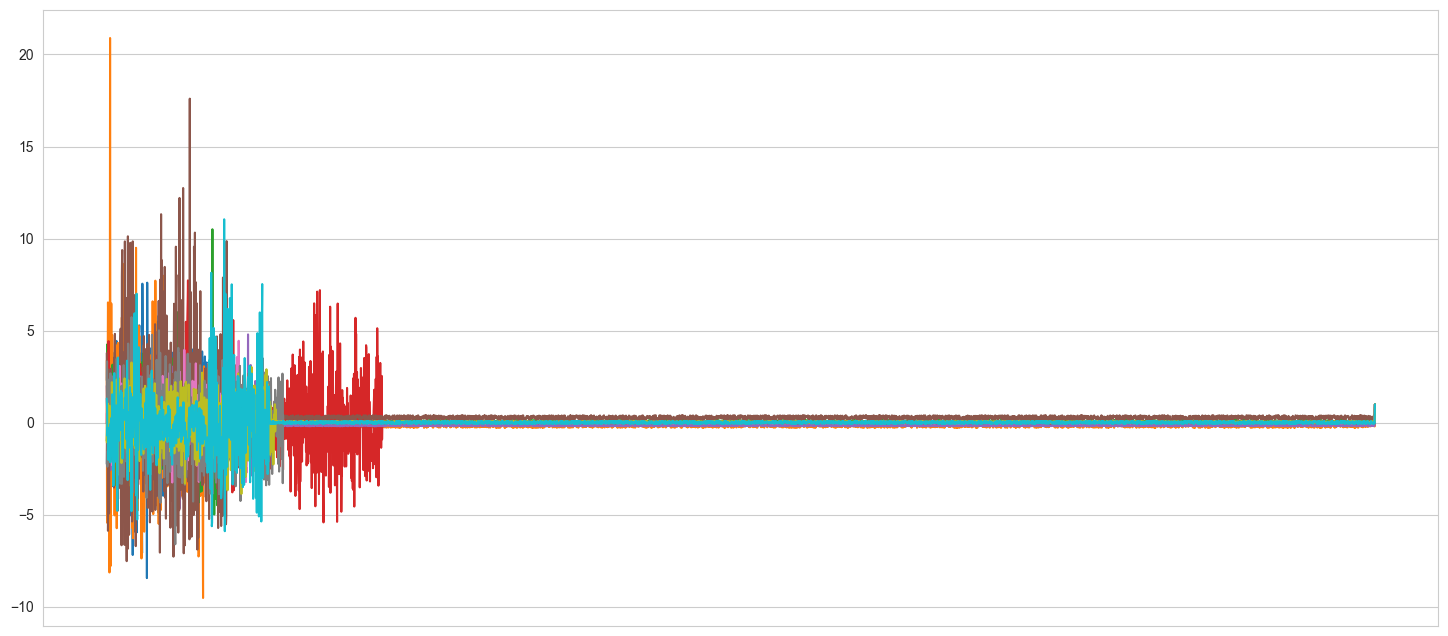

In [20]:
plt.figure(figsize=(18, 8))
for idx in range(10):
    plt.plot(df_train.iloc[idx, :])
plt.xticks([])
plt.show()

## Data s cílovým atributem _0_


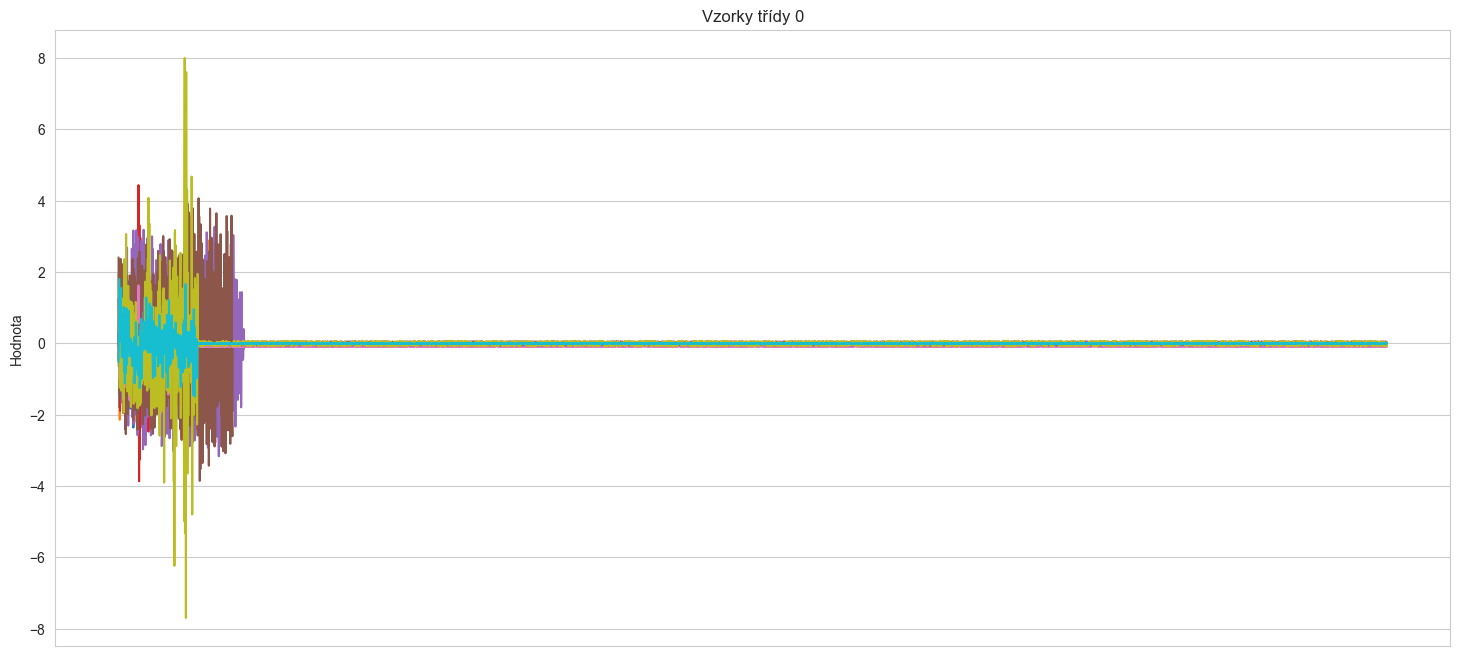

In [21]:
plt.figure(figsize=(18, 8))
negative_indices = df_test[df_test.get("ClassLabel") == 0].index[:10]
for idx in negative_indices:
    plt.plot(df_test.iloc[idx, :-1])
plt.title("Vzorky třídy 0")
plt.xticks([])
plt.ylabel("Hodnota")
plt.show()

## Data s cílovým atributem _1_


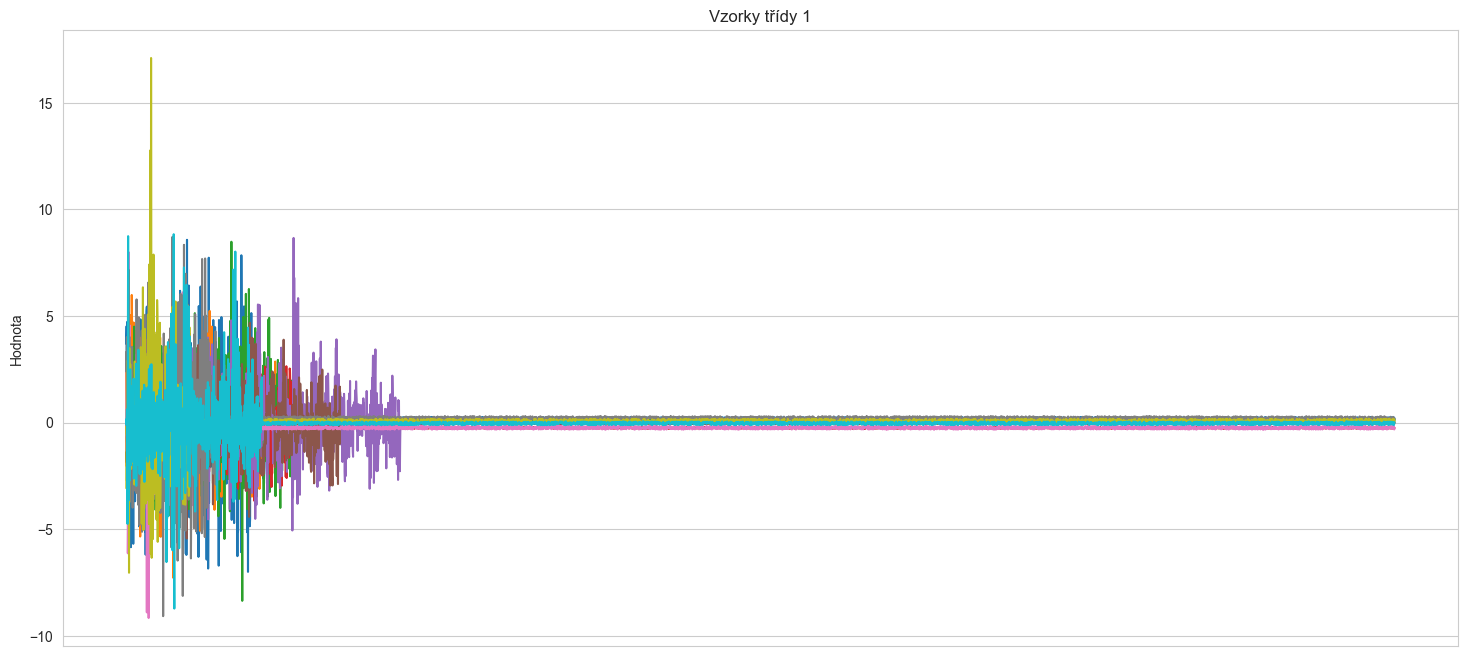

In [22]:
plt.figure(figsize=(18, 8))
negative_indices = df_test[df_test.get("ClassLabel") == 1].index[:10]
for idx in negative_indices:
    plt.plot(df_test.iloc[idx, :-1])
plt.title("Vzorky třídy 1")
plt.xticks([])
plt.ylabel("Hodnota")
plt.show()

# Příprava data


In [23]:
X_train = df_train.drop(columns='ClassLabel').values
Y_train = df_train['ClassLabel'].values
X_test = df_test.drop(columns='ClassLabel').values
Y_test = df_test['ClassLabel'].values

In [24]:
print("Unique values in Y_train:", np.unique(Y_train))
print("Unique values in Y_test:", np.unique(Y_test))

Unique values in Y_train: [0 1]
Unique values in Y_test: [0 1]


# Klasifikace pomocí strojového učení


## Decision Tree


In [25]:
dt = DecisionTreeClassifier(random_state=seed)
dt.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=42)

In [26]:
y_test_predictions_dt = dt.predict(X_test)
print(classification_report(Y_test, y_test_predictions_dt))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87       381
           1       0.85      0.88      0.87       370

    accuracy                           0.87       751
   macro avg       0.87      0.87      0.87       751
weighted avg       0.87      0.87      0.87       751



## Random Forest


In [27]:
rf = RandomForestClassifier(random_state=seed)
rf.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [28]:
y_test_predictions_rf = rf.predict(X_test)
print(classification_report(Y_test, y_test_predictions_rf))

              precision    recall  f1-score   support

           0       0.94      0.88      0.91       381
           1       0.89      0.95      0.92       370

    accuracy                           0.91       751
   macro avg       0.92      0.92      0.91       751
weighted avg       0.92      0.91      0.91       751



## Gradient Boosting


In [29]:
gb = GradientBoostingClassifier(random_state=seed)
gb.fit(X_train, Y_train)

GradientBoostingClassifier(random_state=42)

In [30]:
y_test_predictions_gb = gb.predict(X_test)
print(classification_report(Y_test, y_test_predictions_gb))

              precision    recall  f1-score   support

           0       0.94      0.91      0.92       381
           1       0.91      0.94      0.92       370

    accuracy                           0.92       751
   macro avg       0.92      0.92      0.92       751
weighted avg       0.92      0.92      0.92       751



# Klasifikace pomocí neuronové sítě


## Příprava dat pro trénování

In [31]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(Y_train, dtype=torch.long)

### Příprava dat pro konvoluční neuronové sítě

V této buňce upravujeme tvar našich tenzorů tak, aby byly kompatibilní s konvolučními vrstvami (`Conv1d`).

Konvoluční vrstvy v PyTorch očekávají vstupní data ve formátu:
- **[batch_size, channels, sequence_length]**

Naše současná data jsou ve formátu:
- **[batch_size, sequence_length]**

Přidáním dimenze kanálů pomocí metody `unsqueeze(1)` transformujeme naše data do požadovaného formátu. V našem případě používáme jednokanálová data (jako u jednorozměrného signálu), takže přidáváme kanál s hodnotou 1.

Toto je běžný krok při zpracování časových řad pomocí konvolučních neuronových sítí, kde každá časová řada je reprezentována jako jednokanálový signál.

In [32]:
X_train_tensor = X_train_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)

In [33]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

In [34]:
print(X_train_tensor.shape)
print(Y_train_tensor.shape)
print(X_test_tensor.shape)
print(Y_test_tensor.shape)

torch.Size([751, 1, 4201])
torch.Size([751])
torch.Size([751, 1, 4201])
torch.Size([751])


#### Trénovací parametry

In [35]:
batch_size = 64
num_epochs = 50
learning_rate = 0.001
class_names = ['0', '1']
num_classes = len(torch.unique(Y_train_tensor))

#### DataLoader

In [36]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### Pomocné funkce

#### Funkce pro trénování modelu

In [37]:
def train_model(model, train_loader, criterion, optimizer, num_epochs, device):
    history = defaultdict(list)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # Print header
    print(f"{'Epoch':<7} | {'Train Loss':<12} | {'Train Acc':<10} | Improvement")
    print("-" * 50)

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        total_samples = 0

        # Training phase
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            train_correct += (outputs.argmax(1) == labels).sum().item()
            total_samples += inputs.size(0)

        # Calculate metrics
        epoch_loss = train_loss / total_samples
        epoch_acc = train_correct / total_samples

        # Store metrics
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        # Check for improvement
        improvement = ""
        if epoch_acc > best_acc:
            improvement = "✓"
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        print(f"{epoch + 1:>3}/{num_epochs:<3} | {epoch_loss:>10.4f} | {epoch_acc:>9.2%} | {improvement}")

    # Load best model weights
    model.load_state_dict(best_model_wts)
    print(f"\nTraining complete! Best accuracy: {best_acc:.2%}")

    return model, history

#### Funkce pro vykreslení trénování

In [38]:
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Trénovací ztráta')
    plt.xlabel('Epocha')
    plt.ylabel('Ztráta')
    plt.legend()
    plt.title('Ztráta během epoch')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['train_acc'], label='Trénovací přesnost')
    plt.xlabel('Epocha')
    plt.ylabel('Přesnost')
    plt.legend()
    plt.title('Přesnost během epoch')

    plt.tight_layout()
    plt.show()


#### Funkce pro vyhodnocení modelu

In [39]:
def evaluate_model(model, test_loader, device, class_names=None):
    model.eval()
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, prediction = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(prediction.cpu().numpy())

    # Calculate metrics
    accuracy = (np.array(all_predictions) == np.array(all_labels)).mean()
    report = classification_report(
        all_labels,
        all_predictions,
        target_names=class_names,
        digits=4,
        zero_division=1,
        output_dict=True
    )

    # Print results
    print(f"\n{' Test Results ':=^40}")
    print(f"Overall Accuracy: {accuracy:.2%}\n")
    print("Classification Report:")
    print(classification_report(all_labels, all_predictions, target_names=class_names, digits=4, zero_division=1))

    # Plot confusion matrix if class_names are provided
    if class_names:
        cm = confusion_matrix(all_labels, all_predictions)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names, cbar=False)
        plt.title('Matice záměny')
        plt.xlabel('Predikce')
        plt.ylabel('Skutečné hodnoty')
        plt.tight_layout()
        plt.show()

    # Return metrics dictionary
    metrics = {
        'Accuracy': accuracy,
        'Precision': report['weighted avg']['precision'],
        'Recall': report['weighted avg']['recall'],
        'F1-score': report['weighted avg']['f1-score']
    }

    return metrics

## Trénování jednotlivých modelů

### RNN

In [40]:
class RNNModel(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(RNNModel, self).__init__()

        self.cnn = nn.Sequential(
            # Block 1
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            # Block 2
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            # Block 3
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # RNN Temporal Processor
        self.rnn = nn.RNN(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            nonlinearity='relu'
        )

        # Classifier Head with Sigmoid
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        # CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove the last dimension 

        # RNN Processing - add a sequence dimension
        cnn_features = cnn_features.unsqueeze(1)  # [batch, 1, features]
        h0 = torch.zeros(2, x.size(0), 128).to(x.device)  # 2 layers
        rnn_out, _ = self.rnn(cnn_features, h0)
        rnn_features = rnn_out[:, -1, :]  # Last timestep

        # Classification
        logits = self.classifier(rnn_features)
        return logits

In [41]:
input_size = 1
hidden_size = 64
num_layers = 3
dropout = 0.5

In [42]:
model = RNNModel(input_size, num_classes).to(device)
torchinfo.summary(model, input_size=(batch_size, input_size, X_train.shape[1]),
                  col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
RNNModel                                 [64, 1, 4201]             [64, 2]                   --
├─Sequential: 1-1                        [64, 1, 4201]             [64, 256, 1]              --
│    └─Conv1d: 2-1                       [64, 1, 4201]             [64, 64, 4201]            512
│    └─BatchNorm1d: 2-2                  [64, 64, 4201]            [64, 64, 4201]            128
│    └─ReLU: 2-3                         [64, 64, 4201]            [64, 64, 4201]            --
│    └─MaxPool1d: 2-4                    [64, 64, 4201]            [64, 64, 2100]            --
│    └─Conv1d: 2-5                       [64, 64, 2100]            [64, 128, 2100]           41,088
│    └─BatchNorm1d: 2-6                  [64, 128, 2100]           [64, 128, 2100]           256
│    └─ReLU: 2-7                         [64, 128, 2100]           [64, 128, 2100]           --
│    └─MaxPool1d: 2-8       

In [43]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [44]:
rnn_model, rnn_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.6498 |    89.21% | ✓
  2/50  |     0.4911 |    96.14% | ✓
  3/50  |     0.3668 |    97.20% | ✓
  4/50  |     0.3345 |    98.27% | ✓
  5/50  |     0.3378 |    97.74% | 
  6/50  |     0.3253 |    98.80% | ✓
  7/50  |     0.3297 |    98.54% | 
  8/50  |     0.3294 |    98.54% | 
  9/50  |     0.3276 |    98.54% | 
 10/50  |     0.3315 |    98.14% | 
 11/50  |     0.3282 |    98.27% | 
 12/50  |     0.3287 |    98.54% | 
 13/50  |     0.3242 |    99.20% | ✓
 14/50  |     0.3270 |    98.80% | 
 15/50  |     0.3276 |    98.54% | 
 16/50  |     0.3322 |    98.00% | 
 17/50  |     0.3228 |    99.07% | 
 18/50  |     0.3252 |    98.67% | 
 19/50  |     0.3237 |    98.93% | 
 20/50  |     0.3204 |    99.33% | ✓
 21/50  |     0.3214 |    99.20% | 
 22/50  |     0.3251 |    98.80% | 
 23/50  |     0.3264 |    98.54% | 
 24/50  |     0.3236 |    99.07% | 
 25/50  |     0.3287 |    98

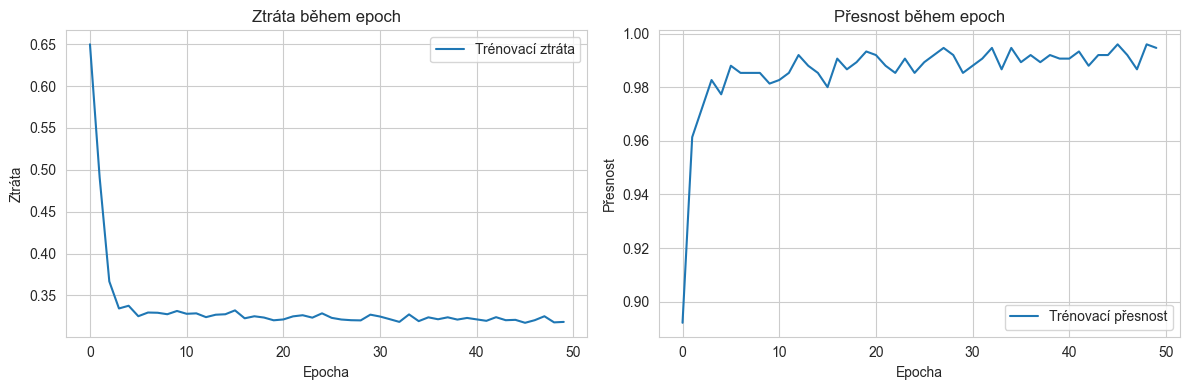

In [45]:
plot_training_history(rnn_history)


============= Test Results =============
Overall Accuracy: 99.20%

Classification Report:
              precision    recall  f1-score   support

           0     0.9921    0.9921    0.9921       381
           1     0.9919    0.9919    0.9919       370

    accuracy                         0.9920       751
   macro avg     0.9920    0.9920    0.9920       751
weighted avg     0.9920    0.9920    0.9920       751



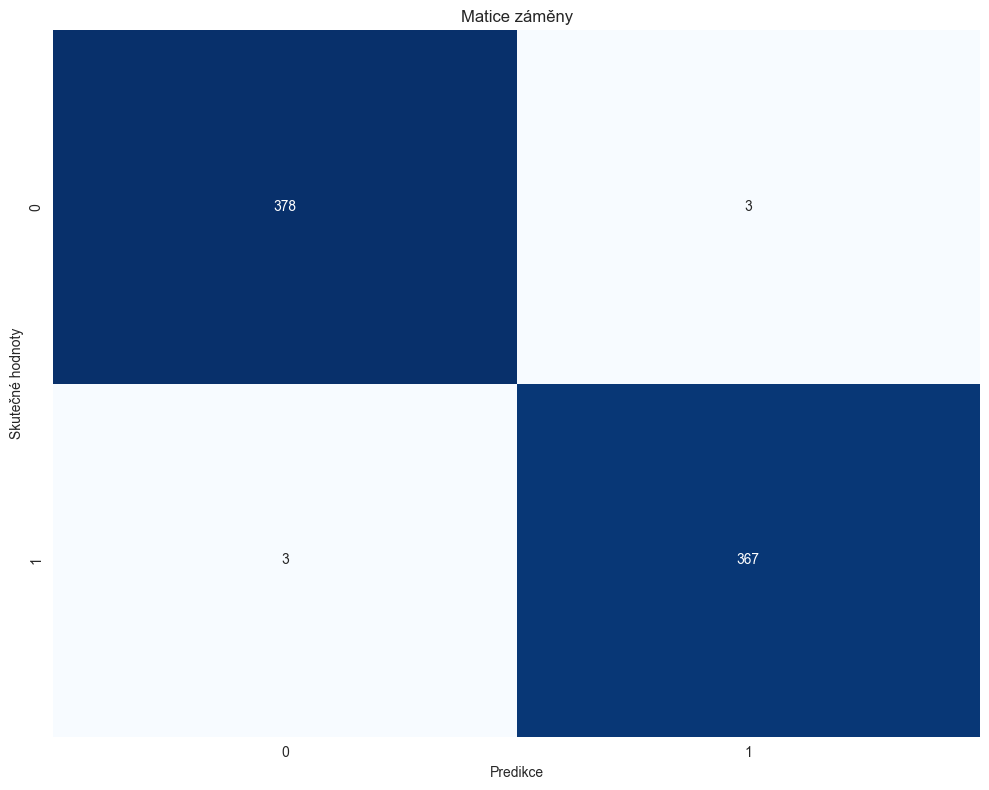

In [46]:
rnn_metrics = evaluate_model(rnn_model, test_loader, device, class_names)

### GRU

In [47]:
class GRUModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=2, num_classes=2, dropout=0.3):
        super(GRUModel, self).__init__()

        # Save parameters as instance attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # 2. GRU Temporal Processor
        self.gru = nn.GRU(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        # 3. Enhanced Classifier with ReLU and Sigmoid
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),

            nn.Linear(hidden_size // 2, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        # 1. CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove length dimension

        # 2. Prepare for GRU (add sequence dimension back)
        gru_input = cnn_features.unsqueeze(1)  # [batch, 1, hidden_size]

        # 3. GRU Processing
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        gru_out, _ = self.gru(gru_input, h0)
        gru_out = gru_out[:, -1, :]  # Last timestep

        # 4. Classification
        logits = self.classifier(gru_out)
        return logits

In [48]:
model = GRUModel(input_size, hidden_size, num_layers, num_classes, dropout).to(device)
torchinfo.summary(model, input_size=(batch_size, input_size, X_train.shape[1]),
                  col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
GRUModel                                 [64, 1, 4201]             [64, 2]                   --
├─Sequential: 1-1                        [64, 1, 4201]             [64, 64, 1]               --
│    └─Conv1d: 2-1                       [64, 1, 4201]             [64, 64, 4201]            512
│    └─BatchNorm1d: 2-2                  [64, 64, 4201]            [64, 64, 4201]            128
│    └─ReLU: 2-3                         [64, 64, 4201]            [64, 64, 4201]            --
│    └─MaxPool1d: 2-4                    [64, 64, 4201]            [64, 64, 2100]            --
│    └─Conv1d: 2-5                       [64, 64, 2100]            [64, 128, 2100]           41,088
│    └─BatchNorm1d: 2-6                  [64, 128, 2100]           [64, 128, 2100]           256
│    └─ReLU: 2-7                         [64, 128, 2100]           [64, 128, 2100]           --
│    └─MaxPool1d: 2-8       

In [49]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [50]:
gru_model, gru_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.6653 |    66.98% | ✓
  2/50  |     0.5918 |    89.21% | ✓
  3/50  |     0.5297 |    95.87% | ✓
  4/50  |     0.4914 |    96.54% | ✓
  5/50  |     0.4562 |    97.07% | ✓
  6/50  |     0.4312 |    98.00% | ✓
  7/50  |     0.4126 |    98.54% | ✓
  8/50  |     0.3956 |    98.67% | ✓
  9/50  |     0.3826 |    98.80% | ✓
 10/50  |     0.3729 |    98.80% | 
 11/50  |     0.3665 |    98.54% | 
 12/50  |     0.3581 |    98.93% | ✓
 13/50  |     0.3603 |    98.14% | 
 14/50  |     0.3517 |    98.93% | 
 15/50  |     0.3501 |    98.67% | 
 16/50  |     0.3455 |    98.67% | 
 17/50  |     0.3415 |    99.07% | ✓
 18/50  |     0.3375 |    99.20% | ✓
 19/50  |     0.3403 |    98.80% | 
 20/50  |     0.3382 |    98.80% | 
 21/50  |     0.3446 |    97.87% | 
 22/50  |     0.3361 |    98.93% | 
 23/50  |     0.3324 |    99.47% | ✓
 24/50  |     0.3345 |    98.93% | 
 25/50  |     0.3329 |

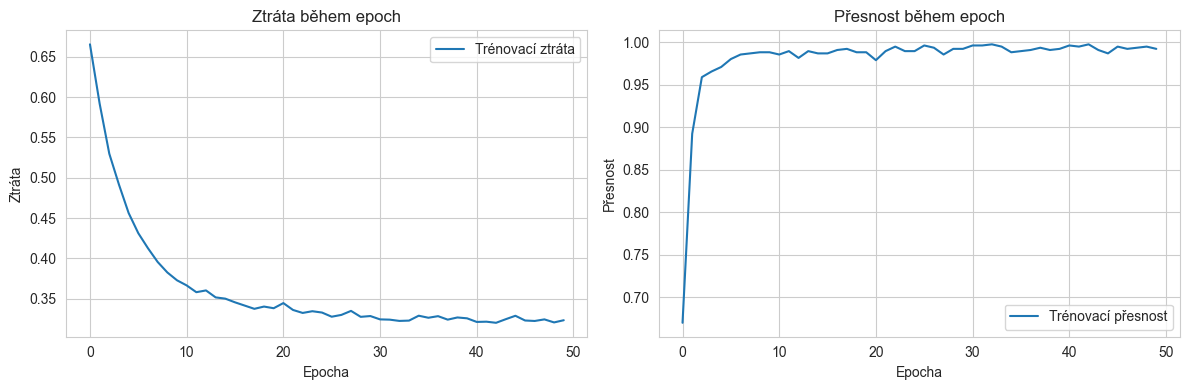

In [51]:
plot_training_history(gru_history)


============= Test Results =============
Overall Accuracy: 98.40%

Classification Report:
              precision    recall  f1-score   support

           0     0.9719    0.9974    0.9845       381
           1     0.9972    0.9703    0.9836       370

    accuracy                         0.9840       751
   macro avg     0.9845    0.9838    0.9840       751
weighted avg     0.9844    0.9840    0.9840       751



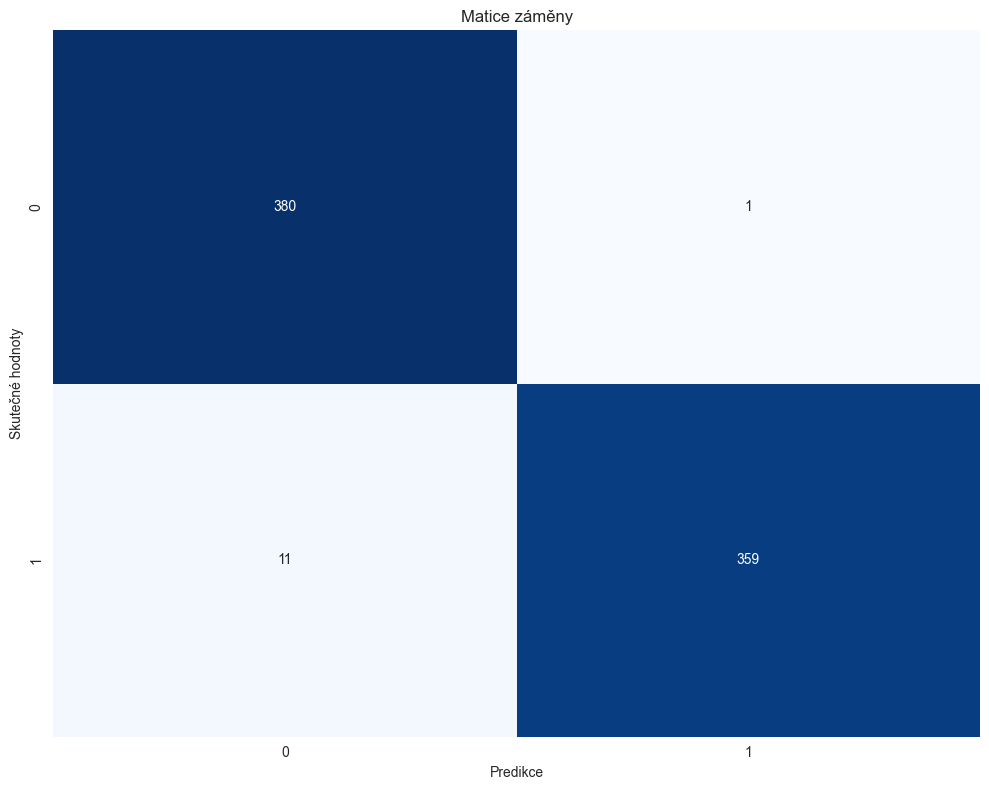

In [73]:
gru_metrics = evaluate_model(gru_model, test_loader, device, class_names)

### LSTM

In [52]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=2, num_classes=2, dropout=0.3):
        super(LSTMModel, self).__init__()

        # Save parameters as instance attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # 2. LSTM Processor
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        # 3. Enhanced Classifier with ReLU and Sigmoid
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_classes),
            nn.Sigmoid()  # Added Sigmoid activation
        )

    def forward(self, x):
        # 1. CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove length dimension

        # 2. Prepare for LSTM (add sequence dimension back)
        lstm_input = cnn_features.unsqueeze(1)  # [batch, 1, hidden_size]

        # 3. LSTM Processing
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(lstm_input, (h0, c0))
        lstm_out = lstm_out[:, -1, :]  # Last timestep

        # 4. Classification
        logits = self.classifier(lstm_out)
        return logits

In [53]:
model = LSTMModel(input_size, hidden_size, num_layers, num_classes, dropout).to(device)
torchinfo.summary(model, input_size=(batch_size, input_size, X_train.shape[1]),
                  col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [64, 1, 4201]             [64, 2]                   --
├─Sequential: 1-1                        [64, 1, 4201]             [64, 64, 1]               --
│    └─Conv1d: 2-1                       [64, 1, 4201]             [64, 64, 4201]            512
│    └─BatchNorm1d: 2-2                  [64, 64, 4201]            [64, 64, 4201]            128
│    └─ReLU: 2-3                         [64, 64, 4201]            [64, 64, 4201]            --
│    └─MaxPool1d: 2-4                    [64, 64, 4201]            [64, 64, 2100]            --
│    └─Conv1d: 2-5                       [64, 64, 2100]            [64, 128, 2100]           41,088
│    └─BatchNorm1d: 2-6                  [64, 128, 2100]           [64, 128, 2100]           256
│    └─ReLU: 2-7                         [64, 128, 2100]           [64, 128, 2100]           --
│    └─MaxPool1d: 2-8       

In [54]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [55]:
lstm_model, lstm_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.6867 |    56.86% | ✓
  2/50  |     0.6436 |    77.10% | ✓
  3/50  |     0.5580 |    93.21% | ✓
  4/50  |     0.5046 |    96.01% | ✓
  5/50  |     0.4626 |    97.47% | ✓
  6/50  |     0.4358 |    97.60% | ✓
  7/50  |     0.4150 |    97.74% | ✓
  8/50  |     0.3944 |    98.40% | ✓
  9/50  |     0.3832 |    98.93% | ✓
 10/50  |     0.3742 |    98.27% | 
 11/50  |     0.3676 |    98.40% | 
 12/50  |     0.3650 |    98.14% | 
 13/50  |     0.3551 |    98.54% | 
 14/50  |     0.3526 |    98.80% | 
 15/50  |     0.3519 |    98.40% | 
 16/50  |     0.3463 |    98.80% | 
 17/50  |     0.3408 |    99.20% | ✓
 18/50  |     0.3449 |    98.40% | 
 19/50  |     0.3423 |    98.40% | 
 20/50  |     0.3375 |    98.93% | 
 21/50  |     0.3329 |    99.47% | ✓
 22/50  |     0.3363 |    98.93% | 
 23/50  |     0.3330 |    98.93% | 
 24/50  |     0.3297 |    99.33% | 
 25/50  |     0.3278 |  

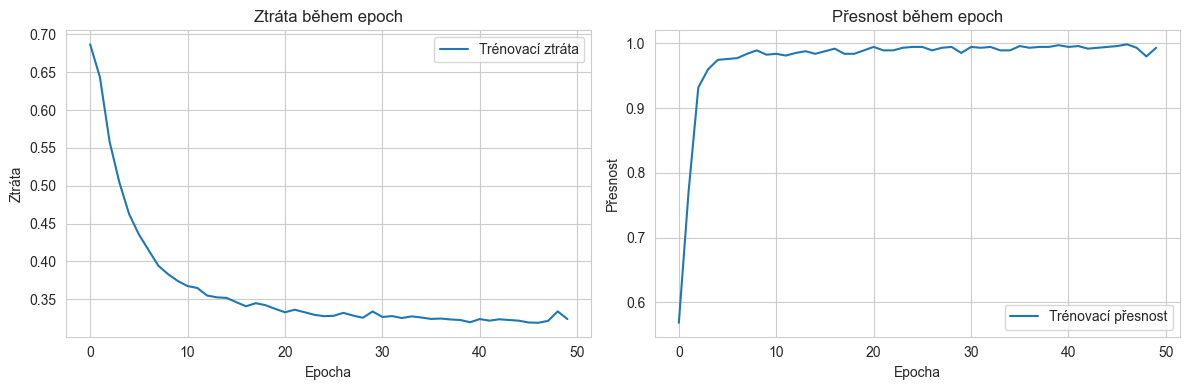

In [56]:
plot_training_history(lstm_history)


============= Test Results =============
Overall Accuracy: 97.87%

Classification Report:
              precision    recall  f1-score   support

           0     0.9973    0.9606    0.9786       381
           1     0.9609    0.9973    0.9788       370

    accuracy                         0.9787       751
   macro avg     0.9791    0.9790    0.9787       751
weighted avg     0.9794    0.9787    0.9787       751



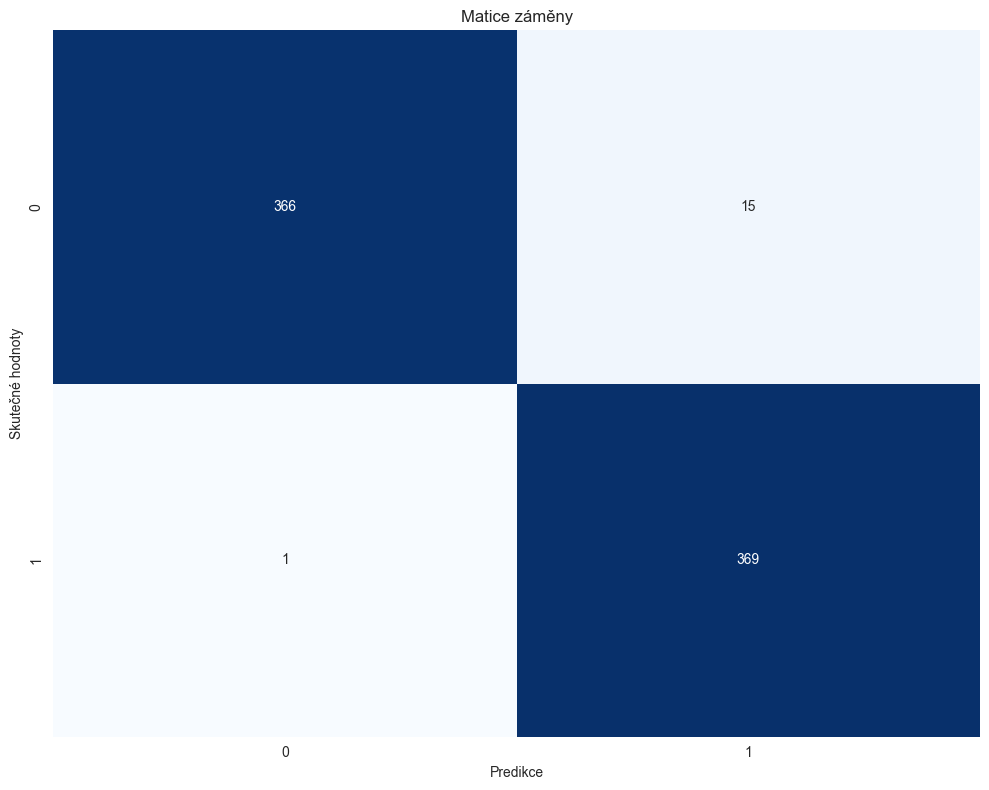

In [57]:
lstm_metrics = evaluate_model(lstm_model, test_loader, device, class_names)

### Biderectional LSTM

In [58]:
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=256, num_layers=2, num_classes=2, dropout=0.3):
        super(BidirectionalLSTMModel, self).__init__()

        # Save parameters as instance attributes
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 1. CNN Feature Extractor
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            nn.Conv1d(128, hidden_size, kernel_size=3, padding=1),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # 2. Bidirectional LSTM Processor
        self.lstm = nn.LSTM(
            input_size=hidden_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        # 3. Enhanced Classifier with ReLU and Sigmoid
        self.classifier = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, hidden_size // 2),  # Multiply by 2 for bidirectional
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, num_classes),
            nn.Sigmoid()  # Added Sigmoid activation like other models
        )

    def forward(self, x):
        # 1. CNN Feature Extraction
        cnn_features = self.cnn(x)
        cnn_features = cnn_features.squeeze(-1)  # Remove length dimension

        # 2. Prepare for LSTM (add sequence dimension back)
        lstm_input = cnn_features.unsqueeze(1)  # [batch, 1, hidden_size]

        # 3. LSTM Processing
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        lstm_out, _ = self.lstm(lstm_input, (h0, c0))
        lstm_out = lstm_out[:, -1, :]  # Last timestep

        # 4. Classification
        logits = self.classifier(lstm_out)
        return logits

In [59]:
model = BidirectionalLSTMModel(input_size, hidden_size, num_layers, num_classes, dropout).to(device)
torchinfo.summary(model, input_size=(batch_size, input_size, X_train.shape[1]),
                  col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
BidirectionalLSTMModel                   [64, 1, 4201]             [64, 2]                   --
├─Sequential: 1-1                        [64, 1, 4201]             [64, 64, 1]               --
│    └─Conv1d: 2-1                       [64, 1, 4201]             [64, 64, 4201]            512
│    └─BatchNorm1d: 2-2                  [64, 64, 4201]            [64, 64, 4201]            128
│    └─ReLU: 2-3                         [64, 64, 4201]            [64, 64, 4201]            --
│    └─MaxPool1d: 2-4                    [64, 64, 4201]            [64, 64, 2100]            --
│    └─Conv1d: 2-5                       [64, 64, 2100]            [64, 128, 2100]           41,088
│    └─BatchNorm1d: 2-6                  [64, 128, 2100]           [64, 128, 2100]           256
│    └─ReLU: 2-7                         [64, 128, 2100]           [64, 128, 2100]           --
│    └─MaxPool1d: 2-8       

In [60]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [61]:
bidirectional_lstm_model, bidirectional_lstm_history = train_model(model, train_loader, criterion, optimizer,
                                                                   num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.6771 |    63.65% | ✓
  2/50  |     0.5851 |    90.81% | ✓
  3/50  |     0.5133 |    96.67% | ✓
  4/50  |     0.4704 |    97.87% | ✓
  5/50  |     0.4408 |    98.40% | ✓
  6/50  |     0.4152 |    98.67% | ✓
  7/50  |     0.3985 |    98.93% | ✓
  8/50  |     0.3888 |    98.14% | 
  9/50  |     0.3775 |    98.54% | 
 10/50  |     0.3686 |    98.67% | 
 11/50  |     0.3616 |    98.54% | 
 12/50  |     0.3562 |    98.80% | 
 13/50  |     0.3500 |    98.93% | 
 14/50  |     0.3515 |    98.40% | 
 15/50  |     0.3483 |    98.27% | 
 16/50  |     0.3408 |    99.33% | ✓
 17/50  |     0.3403 |    98.80% | 
 18/50  |     0.3419 |    98.93% | 
 19/50  |     0.3406 |    98.67% | 
 20/50  |     0.3394 |    98.67% | 
 21/50  |     0.3356 |    98.80% | 
 22/50  |     0.3324 |    99.20% | 
 23/50  |     0.3339 |    98.80% | 
 24/50  |     0.3326 |    98.93% | 
 25/50  |     0.3316 |    9

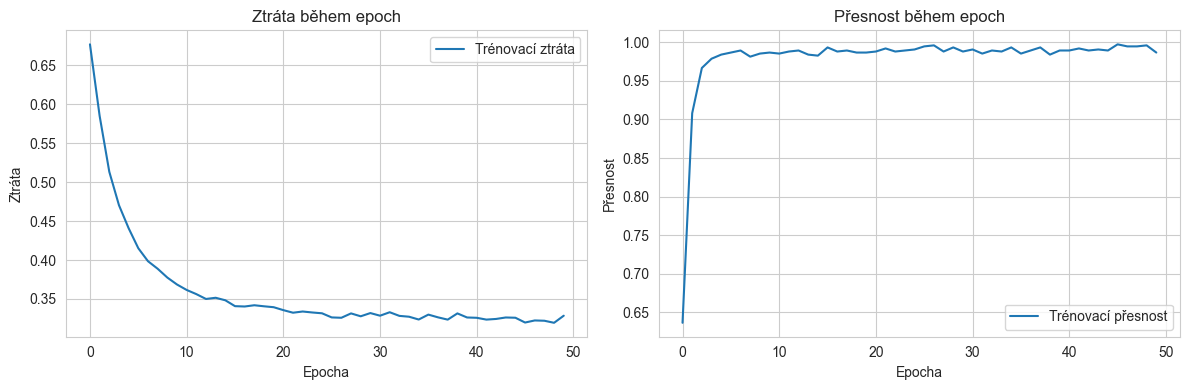

In [62]:
plot_training_history(bidirectional_lstm_history)


============= Test Results =============
Overall Accuracy: 92.68%

Classification Report:
              precision    recall  f1-score   support

           0     0.8739    1.0000    0.9327       381
           1     1.0000    0.8514    0.9197       370

    accuracy                         0.9268       751
   macro avg     0.9369    0.9257    0.9262       751
weighted avg     0.9360    0.9268    0.9263       751



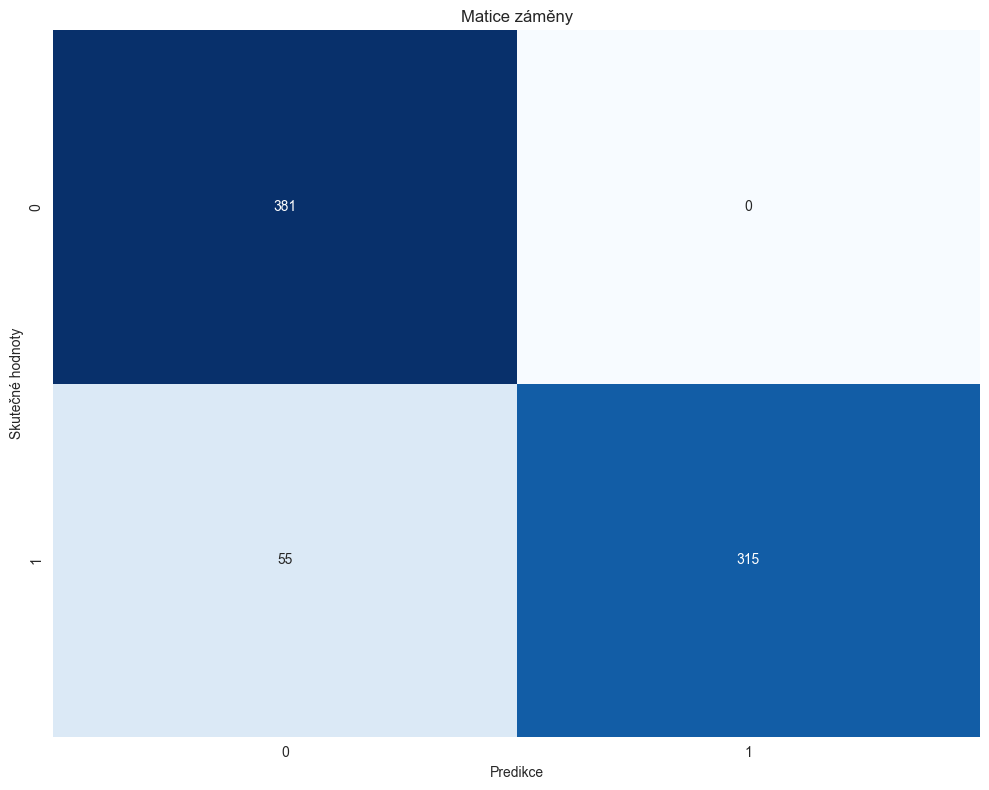

In [63]:
bidirectional_lstm_metrics = evaluate_model(bidirectional_lstm_model, test_loader, device, class_names)

### CNN

In [64]:
class CNNModel(nn.Module):
    def __init__(self, input_channels=1, num_classes=2):
        super(CNNModel, self).__init__()

        # Feature extraction with CNN blocks - reduced to 3 blocks
        self.features = nn.Sequential(
            # Block 1
            nn.Conv1d(input_channels, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2),

            # Block 2
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.MaxPool1d(2),

            # Block 3
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )

        # Classifier head
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        # Feature extraction
        x = self.features(x)

        # Flatten
        x = x.view(x.size(0), -1)

        # Classification
        x = self.classifier(x)
        return x

In [65]:
model = CNNModel(input_size, num_classes).to(device)
torchinfo.summary(model, input_size=(batch_size, input_size, X_train.shape[1]),
                  col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CNNModel                                 [64, 1, 4201]             [64, 2]                   --
├─Sequential: 1-1                        [64, 1, 4201]             [64, 256, 1]              --
│    └─Conv1d: 2-1                       [64, 1, 4201]             [64, 64, 4201]            512
│    └─BatchNorm1d: 2-2                  [64, 64, 4201]            [64, 64, 4201]            128
│    └─ReLU: 2-3                         [64, 64, 4201]            [64, 64, 4201]            --
│    └─MaxPool1d: 2-4                    [64, 64, 4201]            [64, 64, 2100]            --
│    └─Conv1d: 2-5                       [64, 64, 2100]            [64, 128, 2100]           41,088
│    └─BatchNorm1d: 2-6                  [64, 128, 2100]           [64, 128, 2100]           256
│    └─ReLU: 2-7                         [64, 128, 2100]           [64, 128, 2100]           --
│    └─MaxPool1d: 2-8       

In [66]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [67]:
cnn_model, cnn_history = train_model(model, train_loader, criterion, optimizer, num_epochs, device)

Epoch   | Train Loss   | Train Acc  | Improvement
--------------------------------------------------
  1/50  |     0.6047 |    89.61% | ✓
  2/50  |     0.4494 |    96.14% | ✓
  3/50  |     0.3755 |    96.67% | ✓
  4/50  |     0.3539 |    97.07% | ✓
  5/50  |     0.3451 |    97.60% | ✓
  6/50  |     0.3361 |    98.27% | ✓
  7/50  |     0.3354 |    98.40% | ✓
  8/50  |     0.3359 |    98.27% | 
  9/50  |     0.3322 |    98.54% | ✓
 10/50  |     0.3336 |    98.00% | 
 11/50  |     0.3310 |    98.40% | 
 12/50  |     0.3375 |    97.60% | 
 13/50  |     0.3348 |    98.27% | 
 14/50  |     0.3313 |    98.14% | 
 15/50  |     0.3314 |    98.14% | 
 16/50  |     0.3311 |    98.54% | 
 17/50  |     0.3289 |    98.67% | ✓
 18/50  |     0.3362 |    98.00% | 
 19/50  |     0.3268 |    99.07% | ✓
 20/50  |     0.3289 |    98.54% | 
 21/50  |     0.3251 |    99.20% | ✓
 22/50  |     0.3264 |    98.80% | 
 23/50  |     0.3276 |    98.54% | 
 24/50  |     0.3272 |    98.67% | 
 25/50  |     0.3342 |  

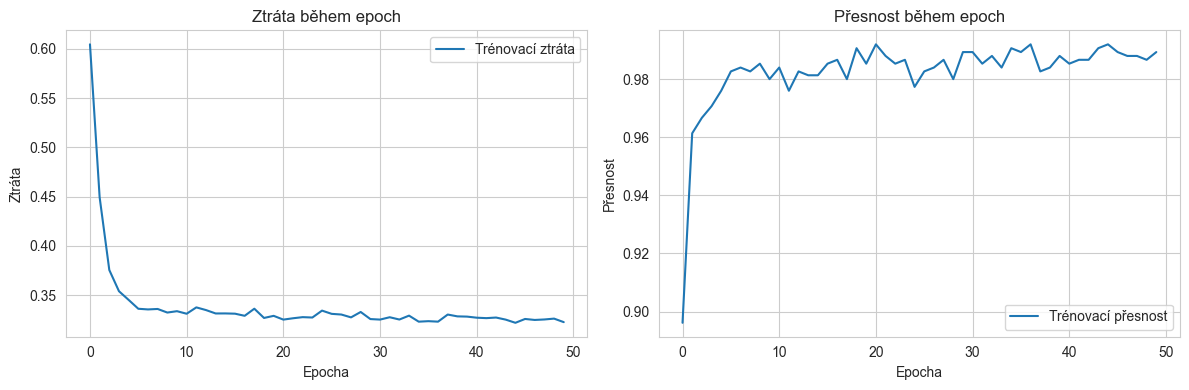

In [68]:
plot_training_history(cnn_history)


============= Test Results =============
Overall Accuracy: 98.27%

Classification Report:
              precision    recall  f1-score   support

           0     0.9694    0.9974    0.9832       381
           1     0.9972    0.9676    0.9822       370

    accuracy                         0.9827       751
   macro avg     0.9833    0.9825    0.9827       751
weighted avg     0.9831    0.9827    0.9827       751



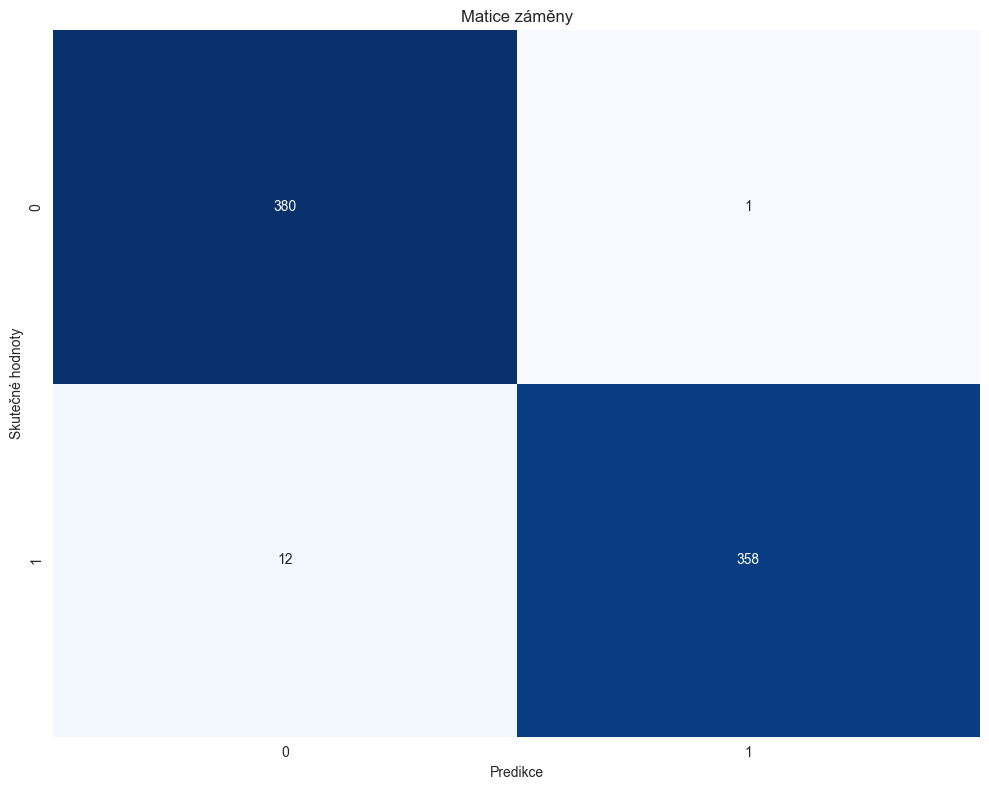

In [69]:
cnn_metrics = evaluate_model(cnn_model, test_loader, device, class_names)

# Výsledky

## Výsledky klasifikace pomocí strojového učení

In [70]:
classic_results = {
    'Model': ['Decision Tree', 'Random Forest', 'Gradient Boosting'],
    'Accuracy': [
        classification_report(Y_test, y_test_predictions_dt, output_dict=True)['accuracy'],
        classification_report(Y_test, y_test_predictions_rf, output_dict=True)['accuracy'],
        classification_report(Y_test, y_test_predictions_gb, output_dict=True)['accuracy']
    ]
}

results_classic = pd.DataFrame(classic_results)
results_classic = results_classic.set_index('Model')
results_classic = results_classic.sort_values(by='Accuracy', ascending=False)

In [71]:
results_classic

,Accuracy
Model,
Gradient Boosting,0.924101
Random Forest,0.914780
Decision Tree,0.865513


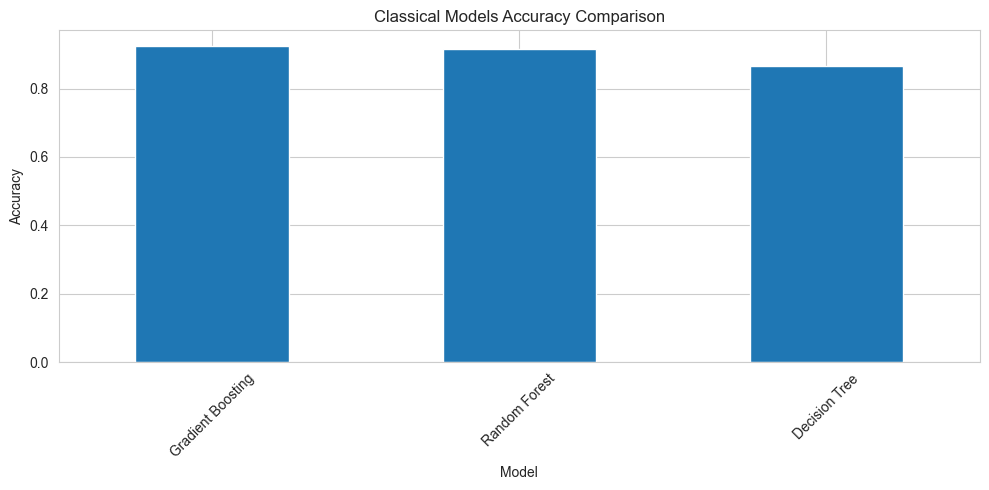

In [72]:
plt.figure(figsize=(10, 5))
results_classic['Accuracy'].plot(kind='bar')
plt.title('Classical Models Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Porovnání výsledků klasifikace pomocí neuronových sítí

In [74]:
nn_results = {
    'Model': ['RNN', 'GRU', 'LSTM', 'Bidirectional LSTM', 'CNN'],
    'Accuracy': [
        rnn_metrics['Accuracy'],
        gru_metrics['Accuracy'],
        lstm_metrics['Accuracy'],
        bidirectional_lstm_metrics['Accuracy'],
        cnn_metrics['Accuracy']
    ],
    'Precision': [
        rnn_metrics['Precision'],
        gru_metrics['Precision'],
        lstm_metrics['Precision'],
        bidirectional_lstm_metrics['Precision'],
        cnn_metrics['Precision']
    ],
    'Recall': [
        rnn_metrics['Recall'],
        gru_metrics['Recall'],
        lstm_metrics['Recall'],
        bidirectional_lstm_metrics['Recall'],
        cnn_metrics['Recall']
    ],
    'F1-score': [
        rnn_metrics['F1-score'],
        gru_metrics['F1-score'],
        lstm_metrics['F1-score'],
        bidirectional_lstm_metrics['F1-score'],
        cnn_metrics['F1-score']
    ]
}

In [76]:
results_nn = pd.DataFrame(nn_results)
results_nn = results_nn.set_index('Model')

In [77]:
results_nn_sorted = results_nn.sort_values(by='Accuracy', ascending=False)
results_nn_sorted

,Accuracy,Precision,Recall,F1-score
Model,,,,
RNN,0.992011,0.992011,0.992011,0.992011
GRU,0.984021,0.984359,0.984021,0.984015
CNN,0.982690,0.983097,0.982690,0.982682
LSTM,0.978695,0.979372,0.978695,0.978693
Bidirectional LSTM,0.926764,0.936003,0.926764,0.926289


<Figure size 1200x600 with 0 Axes>

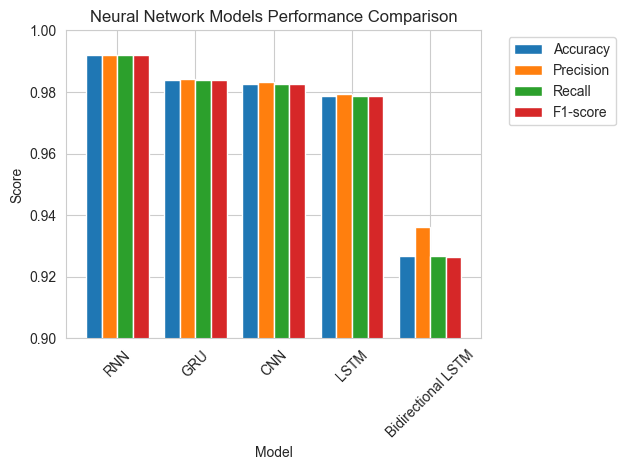

In [78]:
plt.figure(figsize=(12, 6))
results_nn_sorted.plot(kind='bar', width=0.8)
plt.title('Neural Network Models Performance Comparison')
plt.ylabel('Score')
plt.ylim(0.9, 1.0)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()